# 02. MOC1res tumor Elf3 KO RNA-seq analysis

MOC1res tumors (Elf3+/+ or Elf3-/-) were engrafted subcutaneously, administered anti-PD1 or IgG treatment, then allowed to grow for 30 days. On day 30 of growth, tumors were dissected, dissociated, and malignant cells were isolated by CD45(+) depletion. Malignant cells were then processed for bulk RNA-seq.

In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

## 0. Read in counts and metadata

In [2]:
# read in and format counts
counts = pd.read_csv('/path/to/RSM008_counts.csv')
counts = counts.rename(columns={'Unnamed: 0': 'Geneid'})
counts = counts.set_index('Geneid')

In [3]:
# remove lowly expressed genes
counts = counts[counts.sum(axis = 1) > 10]

In [4]:
# remove duplicated genes (usually just 'Bfar', which throws an error)
counts = counts[~counts.index.duplicated()]

In [5]:
# transpose for DESeq
counts = counts.T

In [6]:
# read in metadata from BRB-seq run
metadata = pd.read_csv('/path/to/counts_manifest.csv')
metadata = metadata.set_index('sample')

In [7]:
# subset to only the samples associated with this experiment
metadata = metadata[metadata.experiment == 'RSM008']

In [8]:
# format metadata
metadata = metadata.drop(columns=['experiment'])

## 1. Perform DESeq2 to obtain size-factor normalized counts matrix; format as AnnData object

In [9]:
# initialize DESeq2
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="condition")

In [10]:
# run
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.11 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 1.24 seconds.

Fitting LFCs...
... done in 0.79 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 11 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [11]:
dds

AnnData object with n_obs × n_vars = 23 × 15419
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [12]:
# create normalized counts matrix
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

In [13]:
# store as AnnData object
adata = sc.AnnData(norm_counts.iloc[:, 1:])
adata.obs = metadata

## 2. Score gene sets

In [14]:
# define gene sets
ICBres = [
    "Prss27", "Elf3", "Desi1", "Ltf", "Pglyrp4", "Pdzk1ip1", "Spns2", "Psca", "Prss22", "Tmprss11g",
    "Gsto1", "Krt19", "Muc20", "Tspan1", "Duoxa2", "Gm13056", "Tmc5", "Ecm1", "Cblc", "Gm9573", 
    "AA467197", "Capn5", "Glrx", "Spns3", "Tmprss11e", "Gm14137", "Trp53inp2", "Slc6a14", "Dynap", 
    "Dusp4", "Cldn23", "AI661453", "Clic5", "Grpel2", "Apol7a", "Gde1", "Mal", "Duox2", "Nupr1", 
    "Cldn1", "P2ry2", "Irf7", "S100a14", "Cdkn2b", "Mall", "Plekhs1", "AC168977.1", "Muc4", "Fxyd4", 
    "Ly6m", "Trim15", "Mal2", "Wnt7b", "Ift22", "Plet1", "Ppbp", "Hist1h1c", "Cryba4", "Krt7", "Hsd17b7", 
    "Clca3b", "Tmprss11f", "Serpinb9f", "Gm48975", "Myzap", "Slc9a3r1", "Pttg1ip", "Slc28a3", "Cidea", 
    "Gm13074", "Gm20234", "Arg1", "4930459C07Rik", "Bspry", "Ccdc12", "Pigr", "Krt23", "1810044K17Rik", 
    "Cyp2d10", "Pbp2", "Cxcl5", "Tmprss4", "Lpcat4", "Ccdc71l", "Arhgap27os1", "Eps8l2", "Tmprss11b", 
    "Serpinb9g", "Csf3", "Ifit1bl1", "Liph", "Ephb3", "AA986860", "Lgals3", "Rassf7", "Gm49439", "Grhl1", 
    "Gfpt1", "Trim16", "Sprr2d"
]

IFNresp = [
    "Gbp6", "Gbp2", "Iigp1", "Cntn1", "Gm4951", "Olfr56", "Mill1", "Cxcl10", 
    "Gbp4", "Ifit3", "Apol10b", "Ifi47", "Gbp5", "Slco2a1", "Prl2c2", "Greb1l", 
    "Gbp8", "Ccl7", "Gm14636", "Gm12185", "Apol9a", "Gm15987", "Adgrb3", 
    "Prl2c3", "Ccl2", "Rgs4", "Ifit1", "Serpina3g", "Irf1", "Asic2", "Cxcl9", 
    "Ms4a4d", "Ifih1", "Gm16685", "Alox12e", "Nrg1", "Ghr", "Gm26907", "Clic4", 
    "Robo2", "F830016B08Rik", "Lama3", "Fam126a", "Gm4841", "Gnb4", "Ammecr1", 
    "C130026I21Rik", "Prl2c5", "Samd5", "Fcgbp", "Plcb1", "Flnb", "Cyp7b1", 
    "Il24", "Alox15", "Ifit3b", "Ncam1", "Csprs", "Cd44", "Il18r1", "Serpinb2", 
    "Efemp1", "Tenm1", "Ccl8", "Slc6a4", "Has2", "Ubd", "Nppb", "Ccl11", "Fap", 
    "Pcdh7", "Gm17268", "Ifi203", "Tnc", "Majin", "Csmd1", "Robo1", "Vcam1", 
    "Irf7", "BC028777", "Npas3", "Itgb6", "Dclk1", "Nek10", "Ly75", "Cfap47", 
    "Slc4a7", "Vegfc", "Cnga1", "Hcn1", "Syt1", "Slco1a5", "Gdnf", "Tenm3", 
    "Erc1", "Skint3", "Pdlim1", "Dnah8", "1700120C14Rik", "Tnip3"
]

In [15]:
# score gene sets
sc.tl.score_genes(adata, ICBres, score_name='ICBres')
sc.tl.score_genes(adata, IFNresp, score_name='IFNresp')

       'Serpinb9f', 'Gm48975', 'Slc9a3r1', 'Gm20234', '4930459C07Rik',
       '1810044K17Rik', 'Cyp2d10', 'Serpinb9g', 'Gm49439'],
      dtype='object')
       'Csprs', 'Gm17268', 'BC028777', 'Npas3', 'Nek10', 'Cfap47', 'Cnga1',
       'Syt1'],
      dtype='object')


In [16]:
# define plotting function
def plot_programs(adata, program, baseline_group, plot_groups):
    """
    create a boxplot with overlayed scatterplot for program of interest
    normalized to a sample of interest
    """
    # define palette for all conditions
    subset_palette = {
        "MOC1res + isotype":        "dimgrey",
        "MOC1res + aPD1":           "red",
        "MOC1res Elf3 KO + isotype":"lightgrey",
        "MOC1res Elf3 KO + aPD1":   "blue"
    }

    # restrict palette to those specified by user
    plot_palette = {gp: subset_palette[gp] for gp in plot_groups}

    # grab both the two plot groups and the baseline
    conds_for_norm = set(plot_groups) | {baseline_group}
    df = (
        adata.obs
        .loc[
            (adata.obs.index != "RS37") &
            (adata.obs["condition"].isin(conds_for_norm))
        ]
        .copy()
    )

    # scale scores to zero and add pseudocount to avoid division by zero
    min_val = df[program].min()
    shifted = df[program] - min_val + 0.01

    # normalize to the mean of the baseline group
    baseline_mean = shifted[df["condition"] == baseline_group].mean()
    df[f"{program}_norm"] = shifted / baseline_mean

    # now drop baseline 
    plot_df = df[df["condition"].isin(plot_groups)].copy()

    # plot
    plt.figure(figsize=(1.25, 1.5))
    sns.boxplot(
        data=plot_df,
        x="condition", y=f"{program}_norm",
        order=plot_groups,
        palette=plot_palette,
        showcaps=False,
        linewidth=0.5,
        fliersize=0,
        width=0.5
    )
    sns.stripplot(
        data=plot_df,
        x="condition", y=f"{program}_norm",
        order=plot_groups,
        color="black",
        size=3,
        jitter=True,
        edgecolor="black",
        linewidth=0.4
    )

    ax = plt.gca()
    # format
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.tick_params(
        axis="both", which="major", direction="out",
        length=5, width=1, colors="black",
        bottom=True, left=True, top=False, right=False
    )
    plt.xticks([], size=9)
    ax.set_yticklabels(["" for _ in ax.get_yticks()])
    plt.xlim(-0.5, len(plot_groups) - 0.5)
    plt.ylabel("", fontsize=9)
    plt.xlabel("")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [17]:
# remove outlier RS37
adata_subset = adata[adata.obs.index!='RS37']

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_44602/3443285697.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["" for _ in ax.get_yticks()])


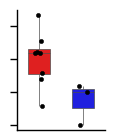

In [18]:
plot_programs(
    adata,
    program="ICBres",
    baseline_group="MOC1res + aPD1",
    plot_groups=["MOC1res + aPD1", "MOC1res Elf3 KO + aPD1"]
)

In [19]:
# statistical comparison
# set program
prog = 'ICBres'
# extract the two groups
group1 = adata_subset[adata_subset.obs['condition'] == "MOC1res + aPD1"].obs[prog]
group2 = adata_subset[adata_subset.obs['condition'] == "MOC1res Elf3 KO + aPD1"].obs[prog]

# MWU test
stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

# report results
print("Mann–Whitney U Test:")
print(f"Statistic = {stat:.3f}")
print(f"P-value   = {pval:.4e}")


Mann–Whitney U Test:
Statistic = 22.000
P-value   = 4.8485e-02


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_44602/3443285697.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["" for _ in ax.get_yticks()])


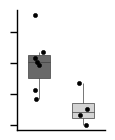

In [20]:
plot_programs(
    adata,
    program="ICBres",
    baseline_group="MOC1res + isotype",
    plot_groups=["MOC1res + isotype", "MOC1res Elf3 KO + isotype"]
)

In [21]:
# statistical comparison
# set program
prog = 'ICBres'
# extract the two groups
group1 = adata_subset[adata_subset.obs['condition'] == "MOC1res + isotype"].obs[prog]
group2 = adata_subset[adata_subset.obs['condition'] == "MOC1res Elf3 KO + isotype"].obs[prog]

# MWU test
stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

# report results
print("Mann–Whitney U Test:")
print(f"Statistic = {stat:.3f}")
print(f"P-value   = {pval:.4e}")


Mann–Whitney U Test:
Statistic = 26.000
P-value   = 2.4242e-02


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_44602/3443285697.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["" for _ in ax.get_yticks()])


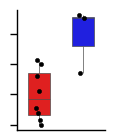

In [22]:
plot_programs(
    adata,
    program="IFNresp",
    baseline_group="MOC1res + aPD1",
    plot_groups=["MOC1res + aPD1", "MOC1res Elf3 KO + aPD1"]
)

In [23]:
# statistical comparison
# set program
prog = 'IFNresp'
# extract the two groups
group1 = adata_subset[adata_subset.obs['condition'] == "MOC1res + aPD1"].obs[prog]
group2 = adata_subset[adata_subset.obs['condition'] == "MOC1res Elf3 KO + aPD1"].obs[prog]

# MWU test
stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

# report results
print("Mann–Whitney U Test:")
print(f"Statistic = {stat:.3f}")
print(f"P-value   = {pval:.4e}")


Mann–Whitney U Test:
Statistic = 2.000
P-value   = 4.8485e-02


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_44602/3443285697.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["" for _ in ax.get_yticks()])


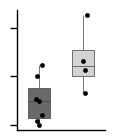

In [24]:
plot_programs(
    adata,
    program="IFNresp",
    baseline_group="MOC1res + isotype",
    plot_groups=["MOC1res + isotype", "MOC1res Elf3 KO + isotype"]
)

In [25]:
# statistical comparison
# set program
prog = 'IFNresp'
# extract the two groups
group1 = adata_subset[adata_subset.obs['condition'] == "MOC1res + isotype"].obs[prog]
group2 = adata_subset[adata_subset.obs['condition'] == "MOC1res Elf3 KO + isotype"].obs[prog]

# MWU test
stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

# report results
print("Mann–Whitney U Test:")
print(f"Statistic = {stat:.3f}")
print(f"P-value   = {pval:.4e}")


Mann–Whitney U Test:
Statistic = 3.000
P-value   = 4.2424e-02


## 3. Plot program marker genes

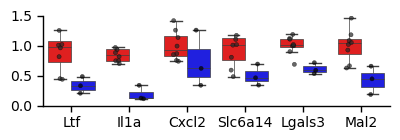

In [26]:
# plot an array of genes between WT and Elf3 KO
# define genes and conditions
genes = ['Ltf','Il1a','Cxcl2','Slc6a14', 'Lgals3','Mal2']
subset_order = [
    "MOC1res + aPD1",
    "MOC1res Elf3 KO + aPD1"
]
subset_palette = {
    "MOC1res + isotype": "dimgrey", 
    "MOC1res + aPD1": "red", 
    "MOC1res Elf3 KO + isotype": "lightgrey", 
    "MOC1res Elf3 KO + aPD1": "blue"
}


# store data as a dataframe
plot_data = []

for gene in genes:
    if gene not in adata.var_names:
        print(f"Skipping missing gene: {gene}")
        continue

    expr = list(adata[:, gene].X.flatten())
    temp_df = adata.obs[['condition']].copy()
    temp_df[gene] = expr
    temp_df = temp_df[temp_df['condition'].isin(subset_order)]

    # normalize per gene to first condition (WT)
    baseline_mean = temp_df.loc[temp_df['condition'] == subset_order[0], gene].mean()
    temp_df['expression_norm'] = temp_df[gene] / baseline_mean
    temp_df['gene'] = gene

 
    plot_data.append(temp_df[['gene', 'condition', 'expression_norm']])

# combine all into one DataFrame
plot_df = pd.concat(plot_data)

# plot
box_width = .4

fig, ax = plt.subplots(figsize=(4.1 ,1.5))

ax = sns.boxplot(
    data=plot_df,
    x='gene', y='expression_norm',
    hue='condition',
    order=genes,
    hue_order=subset_order,
    palette=subset_palette,
    showcaps=True,
    width=.8,
    fliersize=0,
    dodge=True,
    medianprops={"linewidth": 0.5},
    whiskerprops={"linewidth": 0.5},
    boxprops={'linewidth': .5}
)

sns.stripplot(
    data=plot_df,
    x='gene', y='expression_norm',
    hue='condition',
    order=genes,
    hue_order=subset_order,
    dodge=True,
    color='black',
    size=3,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.7,
    ax=ax
)

# remove legends
ax.legend_.remove()

# format axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.tick_params(direction='out', length=4, width=1, colors='black')
plt.xlabel('')
plt.ylabel('')
plt.ylim(0,1.5)
plt.tight_layout()
plt.savefig('ICBres_gex.png', dpi=600)
plt.show()

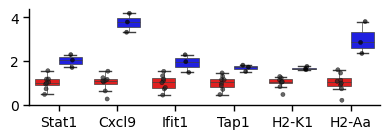

In [27]:
# plot an array of genes between WT and Elf3 KO
# define genes and conditions
genes = ['Stat1','Cxcl9', 'Ifit1', 'Tap1','H2-K1','H2-Aa']
subset_order = [
    "MOC1res + aPD1",
    "MOC1res Elf3 KO + aPD1"
]
subset_palette = {
    "MOC1res + isotype": "dimgrey", 
    "MOC1res + aPD1": "red", 
    "MOC1res Elf3 KO + isotype": "lightgrey", 
    "MOC1res Elf3 KO + aPD1": "blue"
}


# store data as a dataframe
plot_data = []

for gene in genes:
    if gene not in adata.var_names:
        print(f"Skipping missing gene: {gene}")
        continue

    expr = list(adata[:, gene].X.flatten())
    temp_df = adata.obs[['condition']].copy()
    temp_df[gene] = expr
    temp_df = temp_df[temp_df['condition'].isin(subset_order)]

    # normalize per gene to first condition (WT)
    baseline_mean = temp_df.loc[temp_df['condition'] == subset_order[0], gene].mean()
    temp_df['expression_norm'] = temp_df[gene] / baseline_mean
    temp_df['gene'] = gene

    plot_data.append(temp_df[['gene', 'condition', 'expression_norm']])

# combine all into one DataFrame
plot_df = pd.concat(plot_data)

# plot
box_width = .4

fig, ax = plt.subplots(figsize=(4 ,1.5))

ax = sns.boxplot(
    data=plot_df,
    x='gene', y='expression_norm',
    hue='condition',
    order=genes,
    hue_order=subset_order,
    palette=subset_palette,
    showcaps=True,
    width=.8,
    fliersize=0,
    dodge=True,
    medianprops={"linewidth": .5},
    whiskerprops={"linewidth": .5},
    boxprops={'linewidth': .5},

)

sns.stripplot(
    data=plot_df,
    x='gene', y='expression_norm',
    hue='condition',
    order=genes,
    hue_order=subset_order,
    dodge=True,
    color='black',
    size=3,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.7,
    ax=ax
)

# remove legends
ax.legend_.remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.tick_params(direction='out', length=4, width=1, colors='black')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('IFNresp_gex.png', dpi=600)
plt.show()

In [28]:
# perform statistical testing for the above genes
# Define your list of genes
genes = ['Ltf','Il1a','Cxcl2','Slc6a14', 'Lgals3','Mal2',
        'Stat1','Cxcl9', 'Ifit1', 'Tap1','H2-K1','H2-Aa'] 

# define condition groups
subset_order = [
    "MOC1res + aPD1",
    "MOC1res Elf3 KO + aPD1"
]

# store results as a list
results = []

# loop through each gene and perform MWU test
for gene in genes:
    
    # extract expression and group info
    expr_df = adata.obs[['condition']].copy()
    expr_df[gene] = list(adata[:, gene].X.flatten())
    expr_df = expr_df[expr_df['condition'].isin(subset_order)]

    # normalize to first group's mean
    baseline_mean = expr_df.loc[expr_df['condition'] == subset_order[0], gene].mean()
    expr_df[f'{gene}_norm'] = expr_df[gene] / baseline_mean

    # get group values
    group1 = expr_df.loc[expr_df['condition'] == subset_order[0], f'{gene}_norm']
    group2 = expr_df.loc[expr_df['condition'] == subset_order[1], f'{gene}_norm']

    # MWU test
    stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

    results.append({
        'Gene': gene,
        'U statistic': stat,
        'P-value': pval
    })

# convert results to dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('P-value')

# display results
results_df


,Gene,U statistic,P-value
1,Il1a,24.0,0.012121
6,Stat1,0.0,0.012121
7,Cxcl9,0.0,0.012121
9,Tap1,0.0,0.012121
10,H2-K1,0.0,0.012121
11,H2-Aa,0.0,0.012121
4,Lgals3,23.0,0.024242
5,Mal2,23.0,0.024242
8,Ifit1,1.0,0.024242
0,Ltf,22.0,0.048485
